# Первичное ознакомление с данными и предобработка

In [1]:
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime, timedelta

In [2]:
visits = pd.read_csv('r/datasets/visits_info_short.csv')
purchases = pd.read_csv('r/datasets/orders_info_short.csv')
costs = pd.read_csv('r/datasets/costs_info_short.csv')

In [3]:
visits.columns = visits.columns.str.lower() 
visits = visits.rename(columns={'session start':'session_start', 'session end':'session_end', 'user id':'user_id'})
visits.session_start = pd.to_datetime(visits.session_start)
visits.session_end = pd.to_datetime(visits.session_end)
visits.head()

,user_id,region,device,channel,session_start,session_end
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


In [4]:
purchases.columns = purchases.columns.str.lower()
purchases = purchases.rename(columns={'user id':'user_id', 'event dt':'event_dt'})
purchases['event_dt'] = pd.to_datetime(purchases.event_dt)
purchases.head()

,user_id,event_dt,revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


In [5]:
costs.columns = costs.columns.str.lower() 
costs.dt = pd.to_datetime(costs.dt).dt.date
costs.head()

,dt,channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


**Привел названия колонок к нижнему регистру, заменил пробелы нижними подчеркиваниями. Привел колонки с датами к типу datetime. Явных и скрытых дубликатов, пропущенных значений не обнаружено**

# Задаем необходимые функции

## Создание профилей

In [6]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, events, ad_costs, event_names=[]):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # добавляем флаги для всех событий из event_names
    for event in event_names:
        if event in events['event_name'].unique():
            profiles[event] = profiles['user_id'].isin(
                events.query('event_name == @event')['user_id'].unique()
            )

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles


## Retention rate

In [7]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

## Conversion rate

In [8]:

# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

## LTV and ROI

In [9]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

## Сглаживание фрейма

In [10]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

## Retention visualization

In [11]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

## Conversion visualization

In [12]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

## LTV and ROI visualization

In [13]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

# Получим профили пользователей

In [14]:
profiles = get_profiles(sessions=visits, orders=purchases, events=[], ad_costs=costs)

In [15]:
profiles

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769
...,...,...,...,...,...,...,...,...,...
150003,999956196527,2019-09-28 08:33:02,TipTop,iPhone,United States,2019-09-28,2019-09-01,False,3.500000
150004,999975439887,2019-10-21 00:35:17,organic,PC,UK,2019-10-21,2019-10-01,False,0.000000
150005,999976332130,2019-07-23 02:57:06,TipTop,iPhone,United States,2019-07-23,2019-07-01,False,2.600000
150006,999979924135,2019-09-28 21:28:09,MediaTornado,PC,United States,2019-09-28,2019-09-01,False,0.205714


**Мы получили 150008 профилей уникальных пользователей с данными о дате "рождения", канале привлечения, устройстве, стоимости привлечения и наличии/отсутствии покупок**

# EDA

## Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих из каждой страны.

In [16]:
users_by_country = profiles.groupby('region').agg({'user_id':'nunique'}).rename(columns={'user_id':'users'})

users_by_country['country_share, %'] = round(users_by_country.users/users_by_country.users.sum() * 100, 2)

payers_by_country = profiles.query('payer==True').groupby('region').agg({'user_id':'nunique'}) \
.rename(columns={'user_id':'payers'})

by_country = users_by_country.merge(payers_by_country, on='region')
by_country['payer_share, %'] = round(by_country['payers']/by_country['users'] * 100, 2)

In [17]:
by_country.sort_values(by='users', ascending=False)

,users,"country_share, %",payers,"payer_share, %"
region,,,,
United States,100002,66.66,6902,6.90
UK,17575,11.72,700,3.98
France,17450,11.63,663,3.80
Germany,14981,9.99,616,4.11


## Какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи? Построим таблицу, отражающую количество пользователей и долю платящих для каждого устройства.

In [18]:
users_by_device = profiles.groupby('device').agg({'user_id':'nunique'}).rename(columns={'user_id':'users'})

users_by_device['device_share, %'] = round(users_by_device.users/users_by_device.users.sum() * 100, 2)

payers_by_device = profiles.query('payer==True').groupby('device').agg({'user_id':'nunique'}).rename(columns= \
                                                                                            {'user_id':'payers'})
by_device = users_by_device.merge(payers_by_device, on='device')
by_device['payer_share, %'] = round(by_device.payers/by_device.users * 100, 2)

In [19]:
by_device.sort_values(by='users', ascending=False)

,users,"device_share, %",payers,"payer_share, %"
device,,,,
iPhone,54479,36.32,3382,6.21
Android,35032,23.35,2050,5.85
PC,30455,20.30,1537,5.05
Mac,30042,20.03,1912,6.36


## Изучим рекламные источники привлечения и определим каналы, из которых пришло больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

In [20]:
users_by_channel = profiles.groupby('channel').agg({'user_id':'nunique'}).rename(columns={'user_id':'users'})
users_by_channel['channel_share, %'] = round(users_by_channel.users/users_by_channel.users.sum() * 100, 2)
payers_by_channel = profiles.query('payer==True').groupby('channel').agg({'user_id':'nunique'}).rename(columns= \
                                                                                            {'user_id':'payers'})
by_channel = users_by_channel.merge(payers_by_channel, on='channel')
by_channel['payer_share, %'] = round(by_channel.payers/by_channel.users * 100, 2)

In [21]:
by_channel.sort_values(by='users', ascending=False)

,users,"channel_share, %",payers,"payer_share, %"
channel,,,,
organic,56439,37.62,1160,2.06
FaceBoom,29144,19.43,3557,12.20
TipTop,19561,13.04,1878,9.60
OppleCreativeMedia,8605,5.74,233,2.71
LeapBob,8553,5.70,262,3.06
WahooNetBanner,8553,5.70,453,5.30
RocketSuperAds,4448,2.97,352,7.91
MediaTornado,4364,2.91,156,3.57
YRabbit,4312,2.87,165,3.83


## Вывод

**Более 60 процентов пользователей приходят из Соединенных Штатов, пользователи из Великобритании, Франции и Германии составляют от 10 до 12%. У пользователей из США так же наибольшая доля покупателей - 6.9%. Можно предположить, что маркетинговые кампании были направлены преимущественно на юзеров из Штатов**

**Распределение по устройствам довольно равномерное, лидер - Айфон с 36%, пользователи Андроид, ПК и Макбуков составляют от 20 до 23,5%.** 

**Конверсия в покупателей выше у пользователей устройств Apple (цены на их продукцию относительно высоки, а клиентская база наиболее широка в богатых странах - а значит, это наиболее платежеспособная аудитория); самая низкая - у ПК**

**Больше всего пользователей пришли естественным образом, однако конверсия в покупателей у них самая низкая - всего 2%. Высокие показатели конверсии показали FaceBoom, lambdaMediaAds и AdNonSense - однако об их успешности говорить рано, пока мы не проанализировали их стоимость**

In [22]:
print('Минимальная дата привлечения', profiles.dt.min())
print('Максимальная дата привлечения',profiles.dt.max())

Минимальная дата привлечения 2019-05-01
Максимальная дата привлечения 2019-10-27


# Маркетинг

## Посчитаем общую сумму расходов на маркетинг. Выясним, как траты распределены по источникам. Визуализируем изменения метрик во времени.

In [23]:
costs_grouped = costs.groupby('channel', as_index=False).agg({'costs':'sum'}) \
.sort_values(by='costs', ascending=False) \
.reset_index(drop=True)
costs_grouped

,channel,costs
0,TipTop,54751.30
1,FaceBoom,32445.60
2,WahooNetBanner,5151.00
3,AdNonSense,3911.25
4,OppleCreativeMedia,2151.25
5,RocketSuperAds,1833.00
6,LeapBob,1797.60
7,lambdaMediaAds,1557.60
8,MediaTornado,954.48
9,YRabbit,944.22


In [24]:
costs['month'] = pd.to_datetime(costs.dt).dt.month
channel_cost = costs.pivot_table(index='month', columns='channel', values='costs', aggfunc='sum')

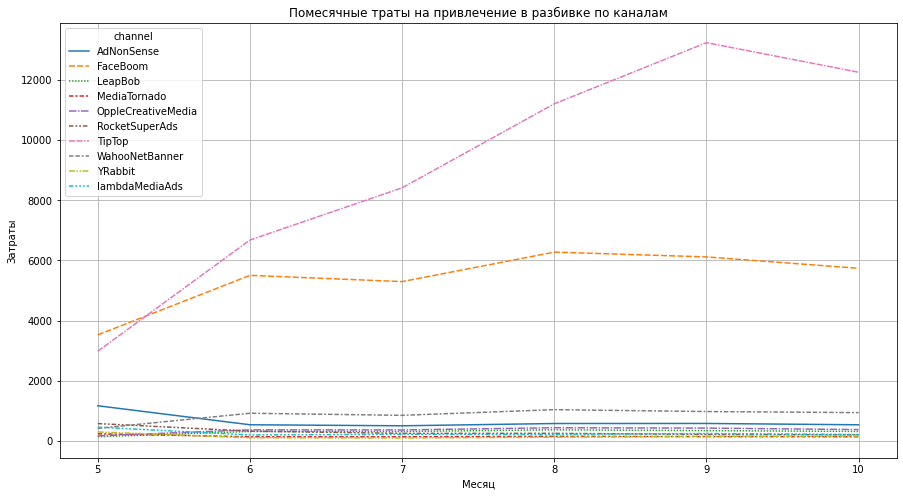

In [25]:
plt.figure(figsize=(15,8))
plt.grid(visible=True)
sns.lineplot(data=channel_cost)
plt.xlabel('Месяц')
plt.ylabel('Затраты')
plt.title('Помесячные траты на привлечение в разбивке по каналам')
plt.show()

**На графике динамика трат на привлечение пользователей с мая по октябрь. Снова выделяются TipTop & FaceBoom, затраты на которые росли. В случае с Faceboom это, на первый взгляд, выглядит оправдано - рост был постепенным и по этому каналу пришло рекордное количество пользователей и покупателей. С TipTop ситуация удручающая - возьмем это на заметку и обратим внимание при дальнейшем анализе.**  

**Затраты на другие каналы привлечения были стабильно небольшими**

## Сколько в среднем стоило привлечение одного пользователя из каждого источника?Посчитаем средний CAC на одного пользователя для всего проекта и для каждого источника трафика. 

In [26]:
profiles.acquisition_cost.mean() # average CAC

0.7032778251826568

In [27]:
profiles.groupby('channel').agg({'acquisition_cost':'mean'}).sort_values(by='acquisition_cost', ascending=False) #average CAC by channel

,acquisition_cost
channel,
TipTop,2.799003
FaceBoom,1.113286
AdNonSense,1.008054
lambdaMediaAds,0.724802
WahooNetBanner,0.602245
RocketSuperAds,0.412095
OppleCreativeMedia,0.250000
YRabbit,0.218975
MediaTornado,0.218717


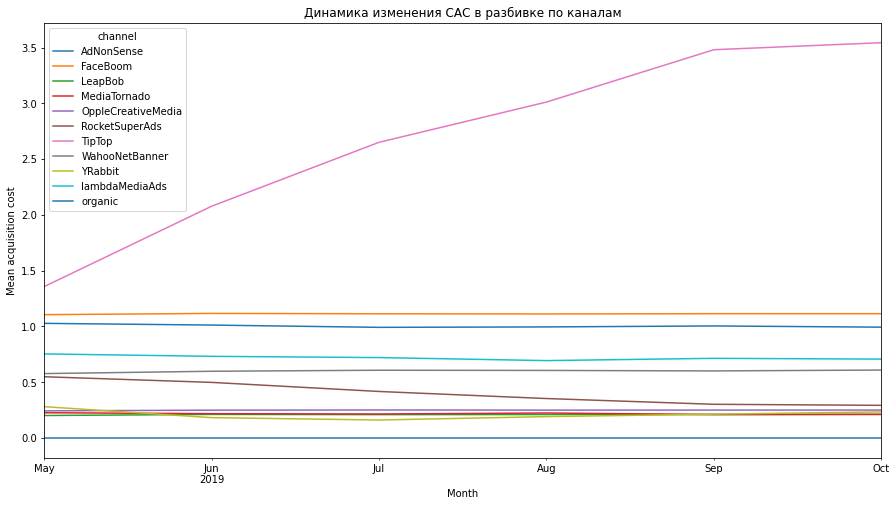

In [28]:
profiles.pivot_table(index='month', columns='channel', values='acquisition_cost', aggfunc='mean') \
.plot(figsize=(15,8))
plt.xlabel('Month')
plt.ylabel('Mean acquisition cost')
plt.title('Динамика изменения САС в разбивке по каналам')
plt.show()

## Вывод

**Средняя стоимость привлечения для всего проекта составила 0.7**

**В разбивке по каналам TipTop снова выбивается на общем фоне - средняя стоимость привлечения пользователя по этому каналу
составила 2.8, следом с большим отставанием идут FaceBoom & AdNonSense, едва превышая отметку в единицу**

**В динамике стоимость привлечения клиентов для всех каналов колеблется незначительно - кроме TipTop, у которого наблюдается устойчивый рост - более чем в два раза за 5 месяцев**

**В целом ситуация следующая - 4 из 5 каналов, на которые было потрачено рекордное количество средств, показывают самые высокие показатели CAC. Если они и были выгодны в прошлом - похоже, на момент анализа их потенциал иссяк**

# Используя графики LTV, ROI и CAC, проанализируем окупаемость рекламы. Будем считать, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. 

## Проанализируем общую окупаемость рекламы. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.


In [29]:
profiles.dt = pd.to_datetime(profiles.dt)

In [30]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(profiles.query('channel != "organic"'), purchases, datetime(2019,10,28), 14)

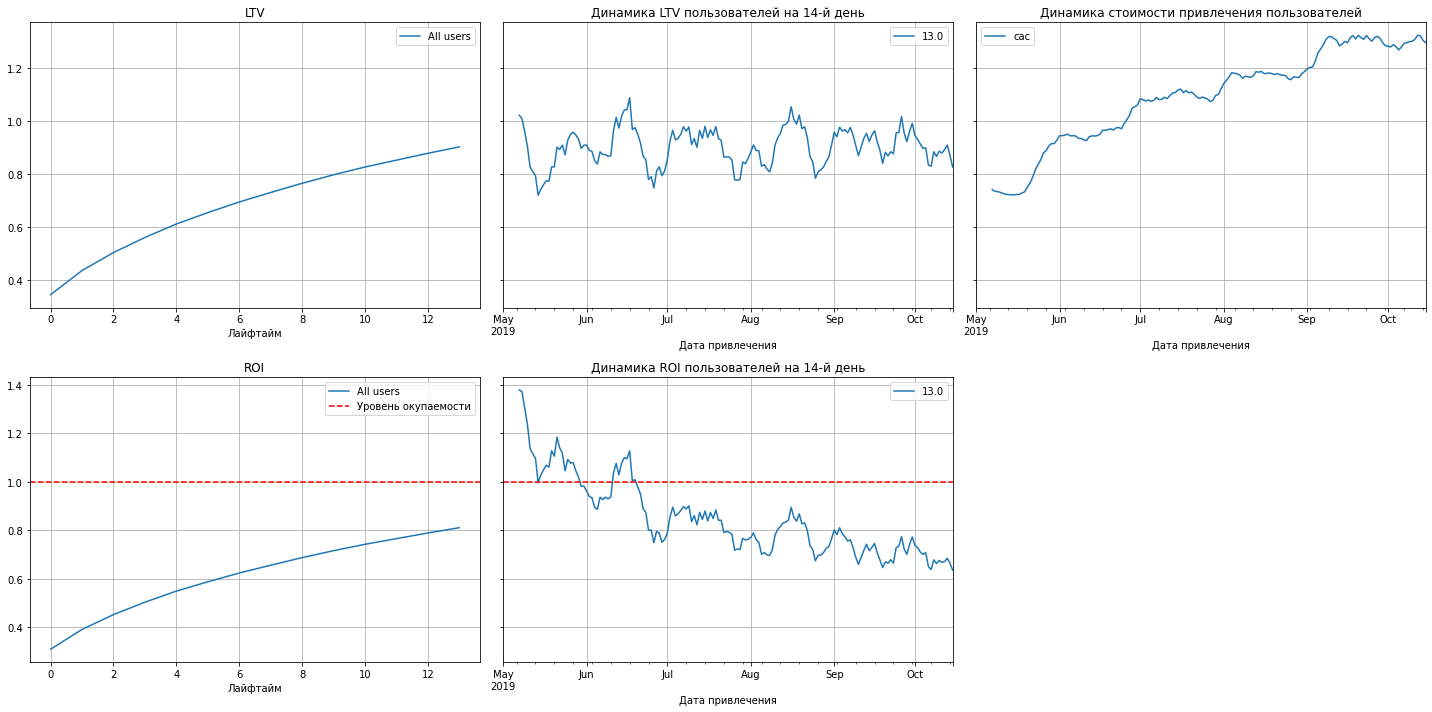

In [31]:
plot_ltv_roi(ltv, ltv_history, roi, roi_history, 14, window=7)

- Общий LTV 14 дня- 0.9, график ROI не касается уровня окупаемости, едва доходя до 80%

- На графике динамики LTV 14 дня колебания в промежутке от 0,8 до 1, в то время как ROI показывает стабильный негативный тренд с небольшими отскоками и не поднимается выше уровня окупаемости с середины июня

- Причина подобной рассинхронизации видна на графике динамики CAC. Расходы на рекламу стабильно растут, и наибольшие скачки CAC по датам приблизительно совпадают с провалами ROI. 

**Мы приходим к неутешительному выводу - наше приложение не окупается, а средства на рекламу тратятся неэффективно**

## Проанализируем окупаемость рекламы с разбивкой по рекламным каналам. 

In [32]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(profiles.query('channel!="organic"'), purchases, datetime(2019,10,28), 14, dimensions=['channel'])

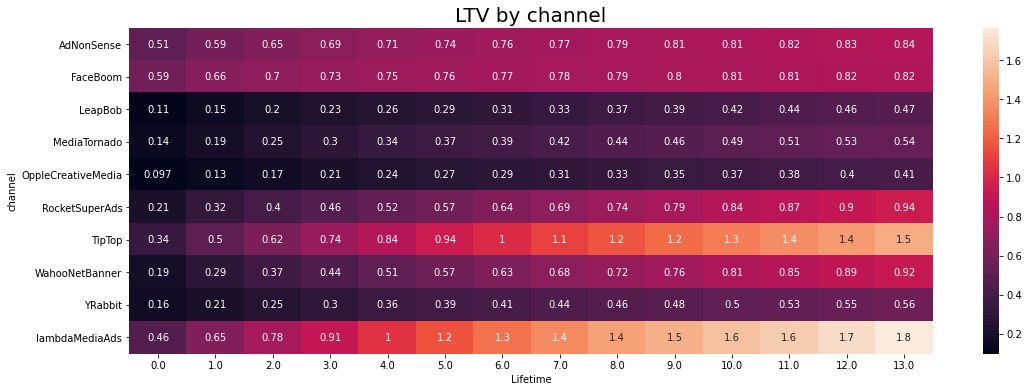

In [33]:
plt.figure(figsize=(18,6))
sns.heatmap(ltv.drop(['cohort_size'], axis=1), annot=True)
plt.xlabel('Channel')
plt.xlabel('Lifetime')
plt.title('LTV by channel', fontsize=20)
plt.show()

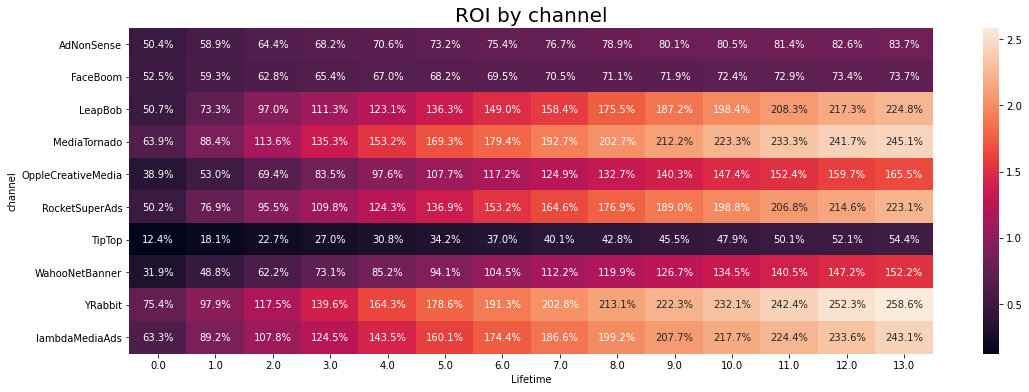

In [34]:
plt.figure(figsize=(18,6))
sns.heatmap(roi.drop(['cohort_size', 'cac'], axis=1), annot=True, fmt='.1%')
plt.xlabel('Channel')
plt.xlabel('Lifetime')
plt.title('ROI by channel', fontsize=20)
plt.show()

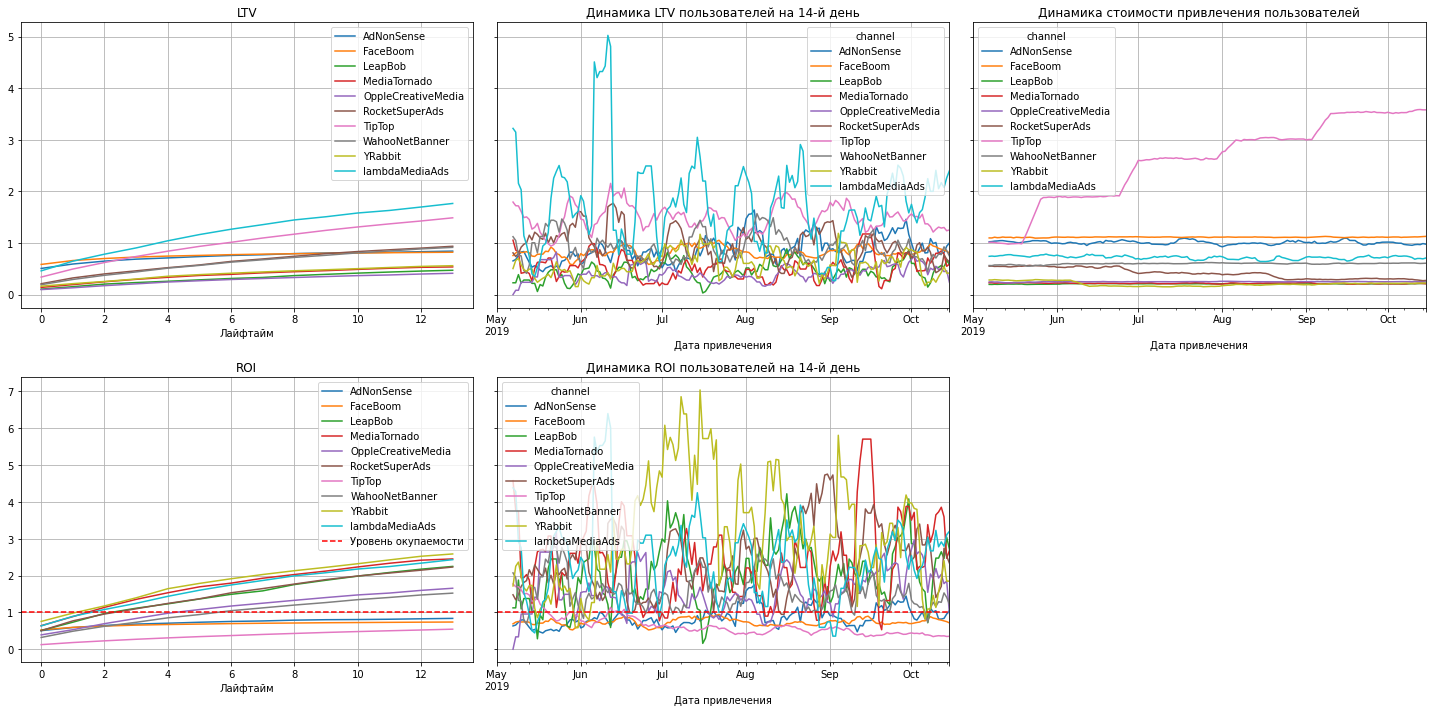

In [35]:
plot_ltv_roi(ltv, ltv_history, roi, roi_history, 14, window=7)

- Самые высокие показатели LTV у каналов lambdaMediaAds, TipTop и RocketSuperAds
- Уровень окупаемости на 14 день не смогли преодолеть 3 канала - TipTop, AdNonsense & FaceBoom. Эти же каналы были в лидерах по общим затратам на рекламу. При этом за рост САС ответственен именно TipTop - CAC для остальных каналов остается на примерно одном и том же уровне весь отчетный период
- А вот YRabbit, lambdaMediaAds, LeapBob, MediaTornado и RocketSuperAds показывают ROI 14 дня более 200% - это весьма неплохие показатели

## Проанализируем окупаемость рекламы с разбивкой по странам. 

In [36]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(profiles.query('channel!="organic"'), purchases, datetime(2019,10,28), 14, dimensions=['region'])

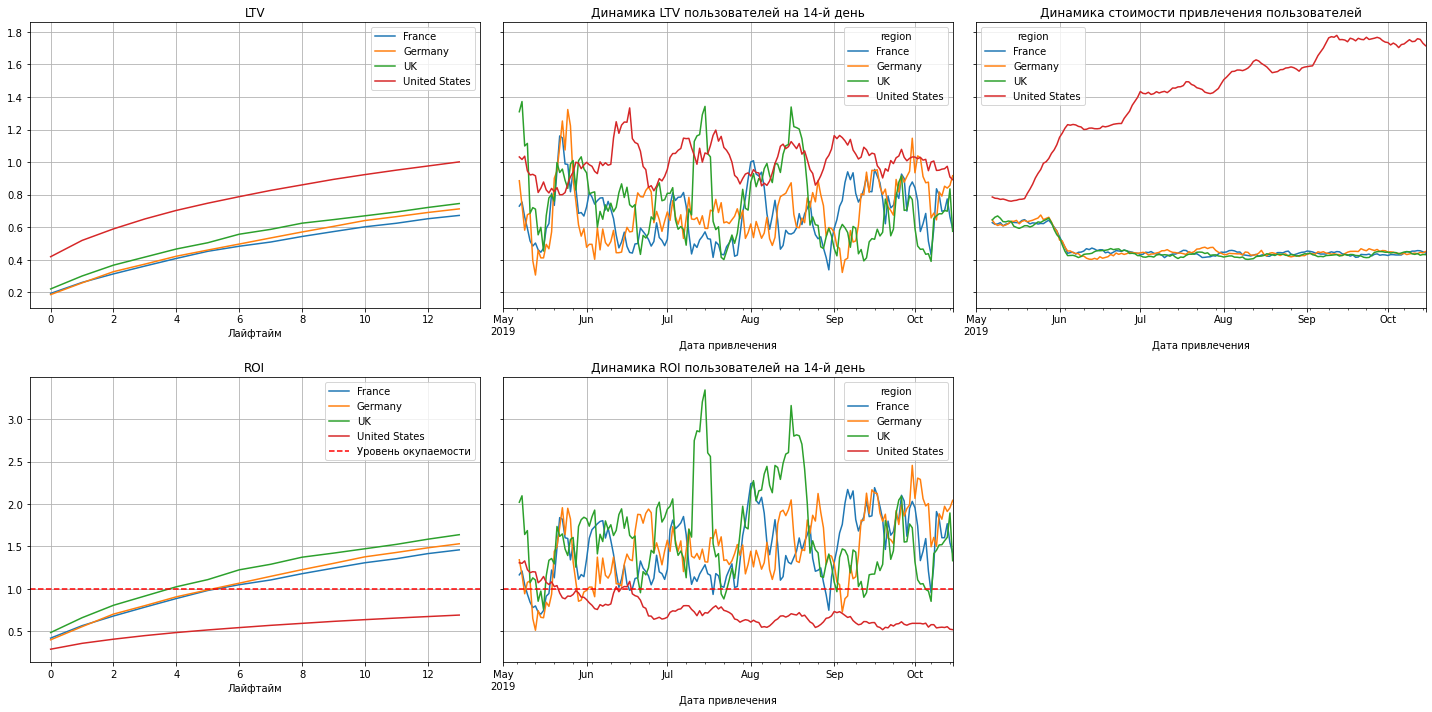

In [37]:
plot_ltv_roi(ltv, ltv_history, roi, roi_history, 14, window=7)

In [38]:
profiles.query('channel == "FaceBoom" or channel == "TipTop"').region.unique()

array(['United States'], dtype=object)

**В разрезе по странам виден существенный вклад Соединенных Штатов в падение рассматриваемых метрик ROI и CAC, несмотря на более высокий LTV по сравнению с другими странами. Самые доорогостоящие и неэффективные маркетинговые кампании по каналам FaceBoom и TipTop были направлены именно на пользователей из США.**

## Проанализируем окупаемость рекламы с разбивкой по девайсам. 

In [39]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(profiles.query('channel!="organic"'), purchases, datetime(2019,10,28), 14, dimensions=['device'])

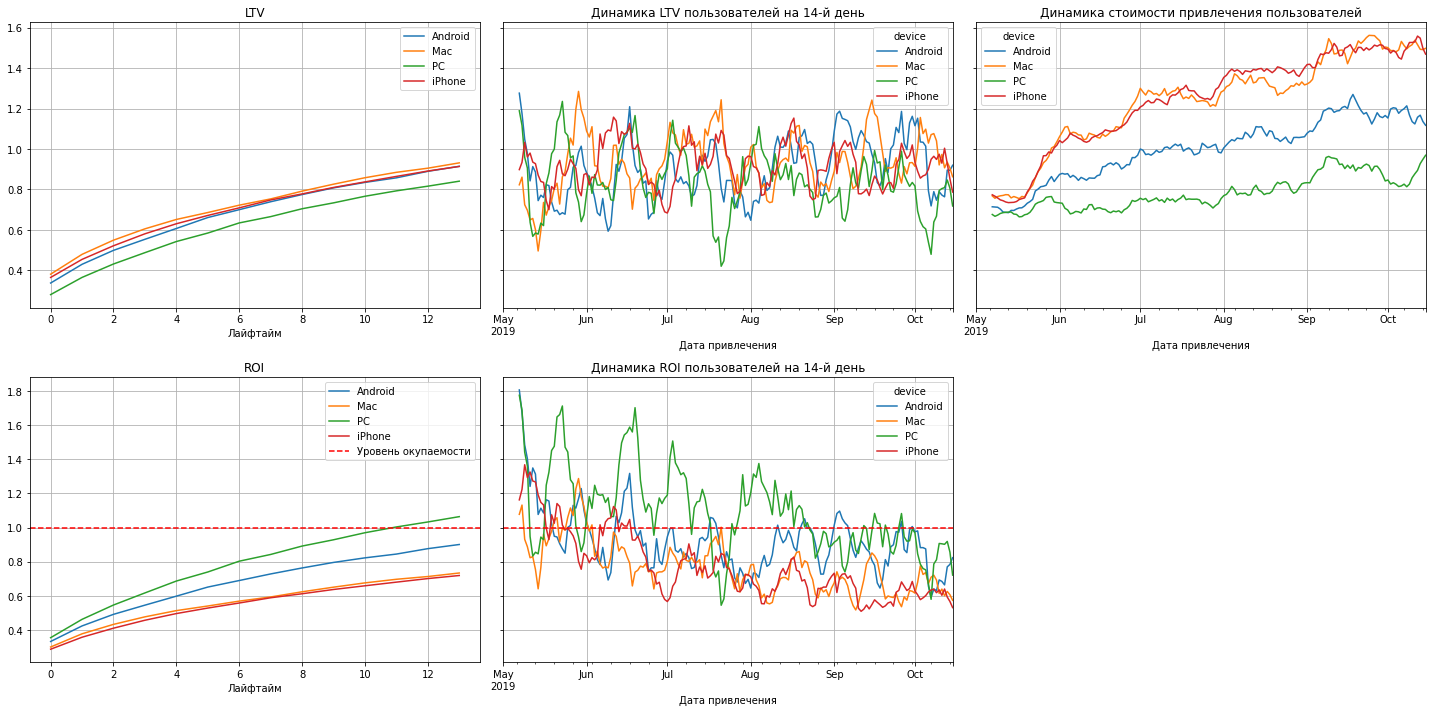

In [40]:
plot_ltv_roi(ltv, ltv_history, roi, roi_history, 14, window=7)

**Несмотря на то, что LTV для ПК ниже, чем для остальных девайсов, ПК - единственная окупающаяся платформа. САС для ПК минимален, а еще это единственная платформа, с которой большинство пользователей приходит органически, а не через рекламные каналы. А вот Макбуки и айфоны окупаются примерно одинаково плохо - и графики САС у них очень схожи**

# Построим и изучим графики конверсии и удержания с разбивкой по устройствам, странам, рекламным каналам.

- Окупается ли реклама в целом?
- Какие устройства, страны и каналы могут снижать окупаемость рекламы?
- Чем могут быть вызваны проблемы окупаемости?
- Каковы возможные причины обнаруженных проблем и промежуточные рекомендации для рекламного отдела.

## Retention Rate

### Retention Rate в разбивке по девайсам

In [41]:
retention_raw, retention, retention_history = get_retention(profiles, visits, datetime(2019,10,28), 14, dimensions=['device'])

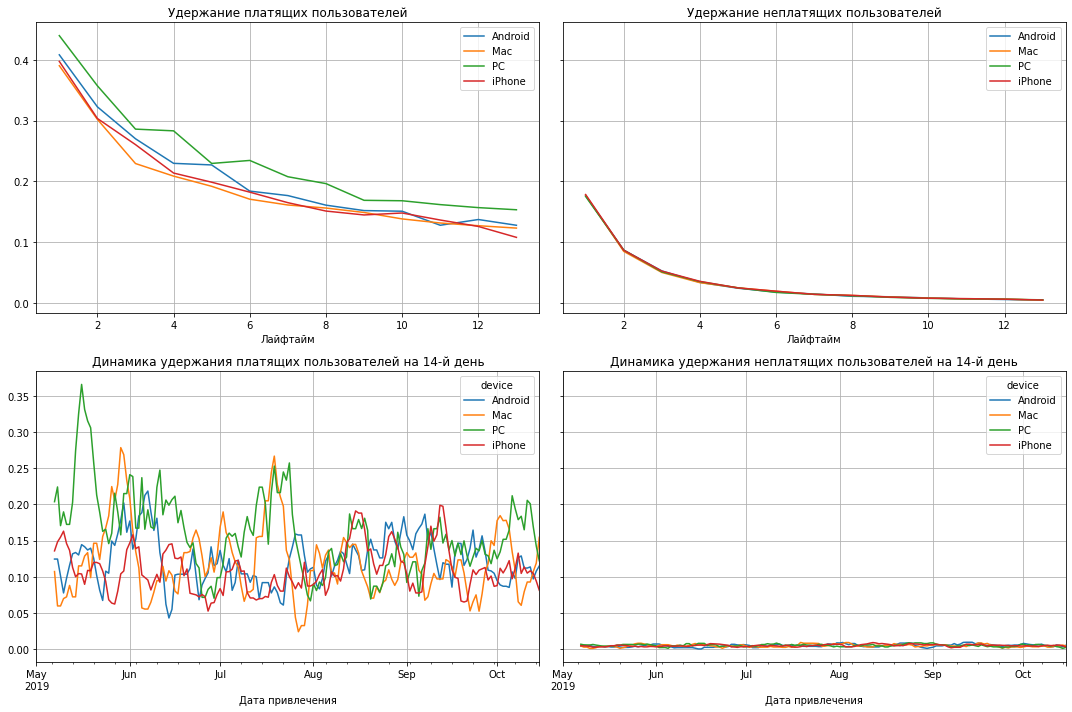

In [42]:
plot_retention(retention, retention_history, 14, window=7)

In [43]:
profiles.groupby(['region', 'device']).agg({'user_id':'nunique'}).sort_values(by=['region', 'user_id'], ascending=False)

user_id
region        device          
United States iPhone     44529
              Mac        24842
              Android    20199
              PC         10432
UK            PC          7138
              Android     5141
              iPhone      3518
              Mac         1778
Germany       PC          5945
              Android     4440
              iPhone      3012
              Mac         1584
France        PC          6940
              Android     5252
              iPhone      3420
              Mac         1838

**Удержание платящих пользователей у ПК во всех лайфтаймах несколько выше, чем у других устройств. Т.к пользователи ПК являются меньшинством в США и большинством в других странах, при анализе удержания в разбивке по странам мы ожидаем увидеть соответствующие изменения**

### Retention Rate в разбивке по странам

In [44]:
retention_raw, retention, retention_history = get_retention(profiles, visits, datetime(2019,10,28), 14, dimensions=['region'])

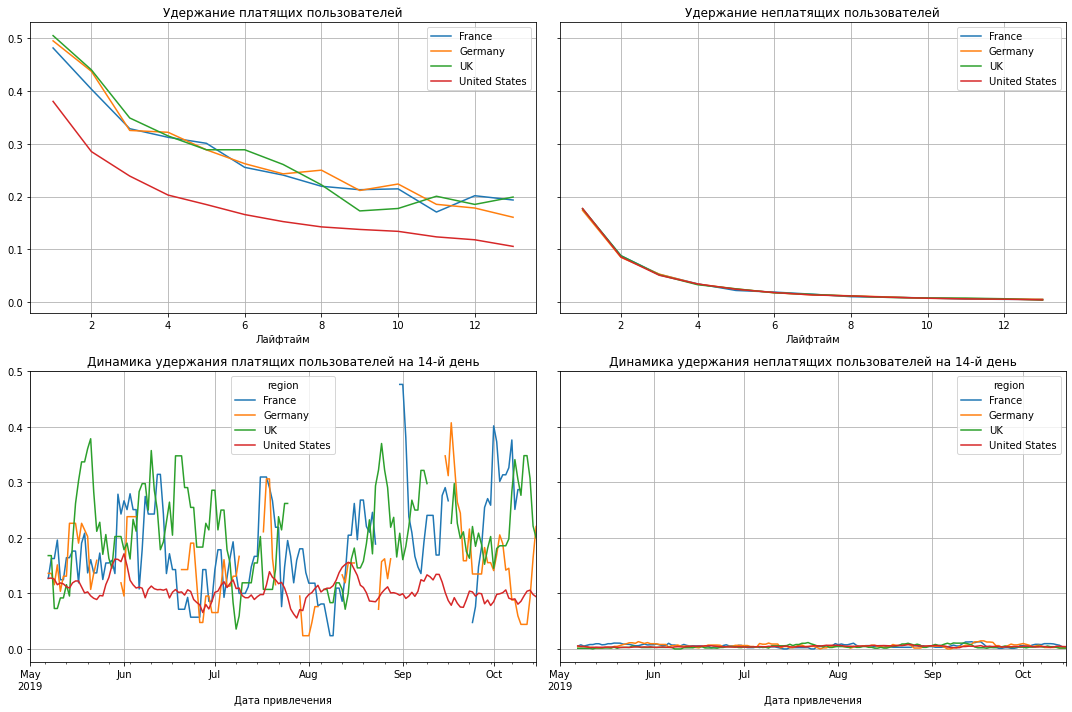

In [45]:
plot_retention(retention, retention_history, 14, window=7)

**Как и ожидалось, удержание пользователей из США заметно отстает от аналогичного показателя для других стран. Теперь проанализируем удержание в разбивке по каналам - ожидаем увидеть неэффективность рекламных кампаний, проводимых в США**

### Retention Rate в разбивке по каналам

In [46]:
retention_raw, retention, retention_history = get_retention(profiles, visits, datetime(2019,10,28), 14, dimensions=['channel'])

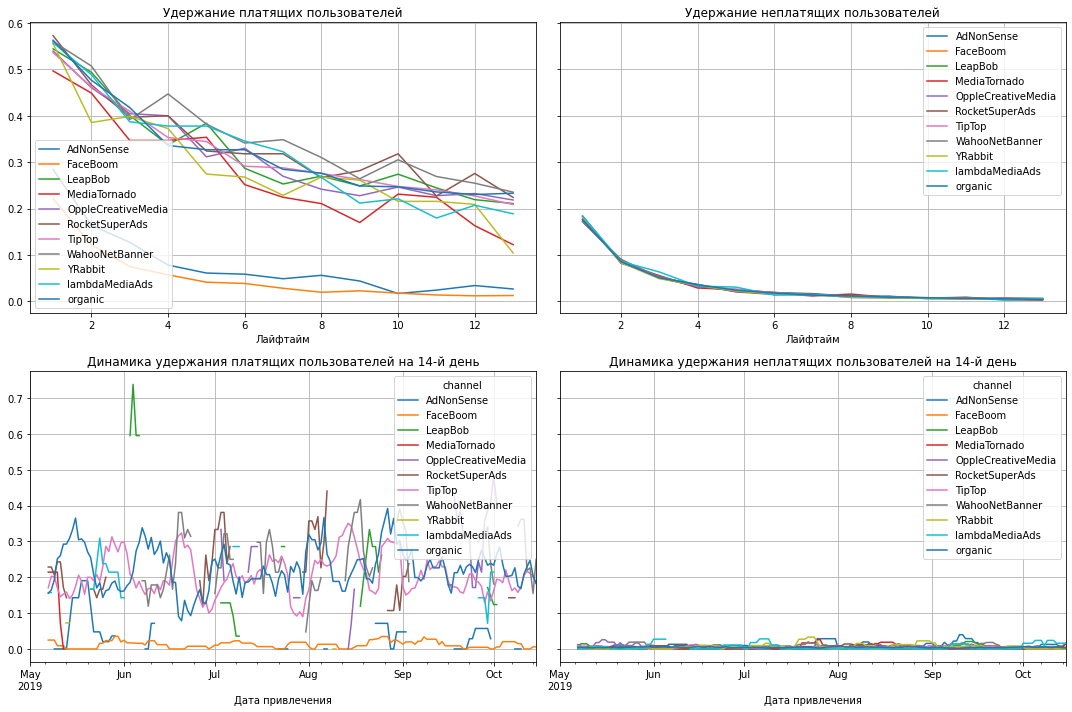

In [47]:
plot_retention(retention, retention_history, 14, window=7)

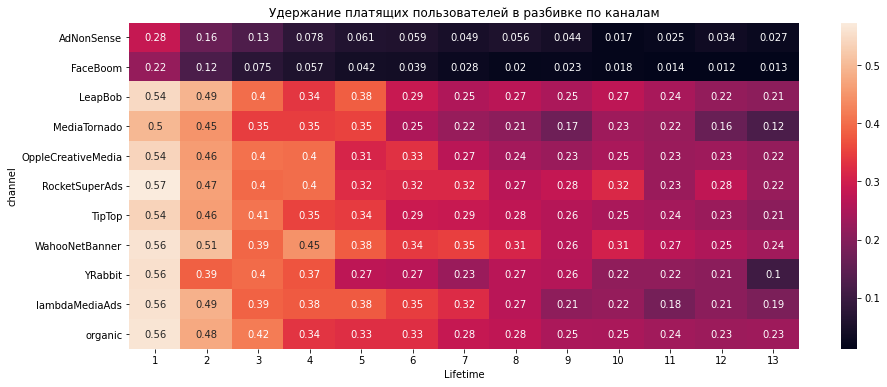

In [48]:
plt.figure(figsize=(15,6))
sns.heatmap(retention.query('payer==True').droplevel(['payer']).drop(['cohort_size', 0], axis=1), annot=True)
plt.title('Удержание платящих пользователей в разбивке по каналам')
plt.xlabel('Lifetime')
plt.show()

**Каналы AdNonSense и FaceBoom показывают крайне низкое удержание во все лайфтаймы, а к концу 2 недели конверсия падает почти до нуля. 
Мы помним, что эти два канала, наряду с TipTop, были лидерами по общему количеству затрат - и все три не окупались. У TipTop с удержанием все относительно неплохо, его убыточность была продиктована постоянным ростом CAC. А у AdNonSense и FaceBoom проблема именно с удержанием. 
Также стоит отметить, что AdNonSense затрагивал пользователей из всех стран, кроме США, а FaceBoom и TipTop - наоборот**

## Conversion Rate

### Conversion Rate в разбивке по девайсам

In [49]:
conversion_raw, conversion, conversion_history = get_conversion(profiles, purchases, datetime(2019,10,28), 14, dimensions=['device'] )

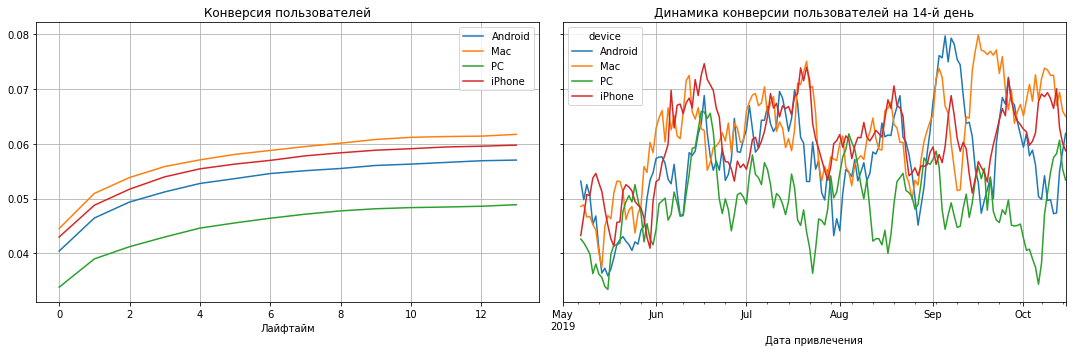

In [50]:
plot_conversion(conversion, conversion_history, 14, window=7)

**Пользователи ПК показывают худшую конверсию, не дотягивая до 5%, а среди пользователей продукции Apple, наоборот, конвертируются минимум 6%.**

### Conversion Rate в разбивке по странам

In [51]:
conversion_raw, conversion, conversion_history = get_conversion(profiles, purchases, datetime(2019,10,28), 14, dimensions=['region'] )

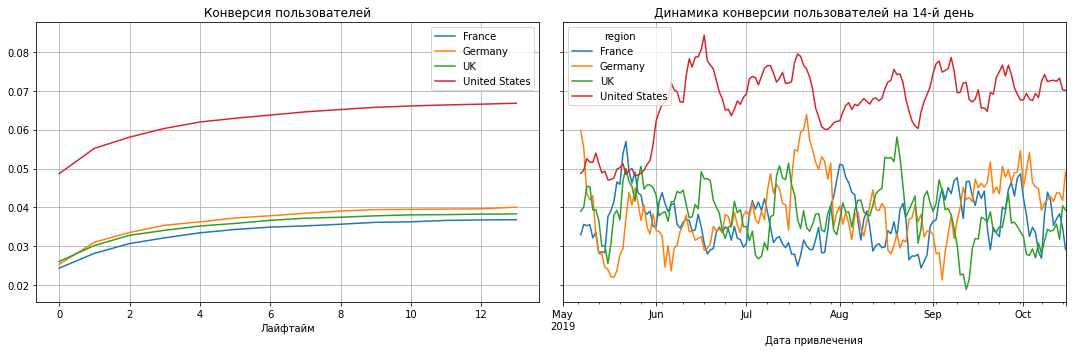

In [52]:
plot_conversion(conversion, conversion_history, 14, window=7)

**Конверсия в разбивке по странам продолжает логику предыдущего графика. Страны, где большая часть пользователей заходят с ПК, показывают низкую конверсию - около 4 процентов. А вот для США, где распространены макбуки и Айфоны,  конверсия превышает 6,5%.**

### Conversion Rate в разбивке по каналам

In [53]:
conversion_raw, conversion, conversion_history = get_conversion(profiles, purchases, datetime(2019,10,28), 14, dimensions=['channel'] )

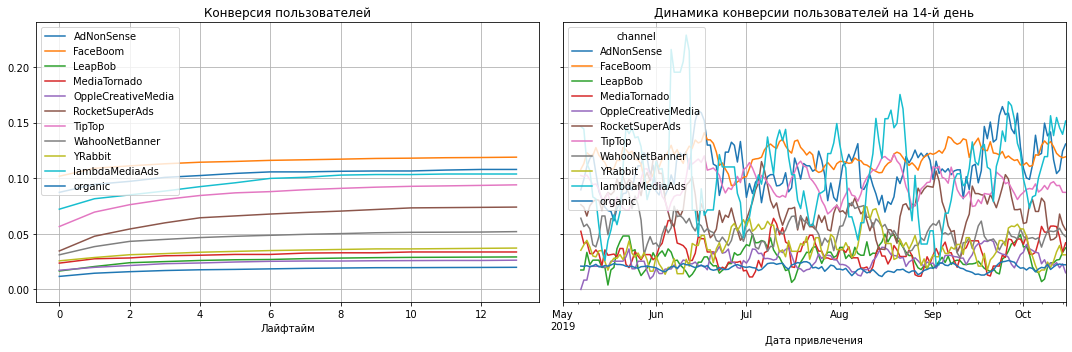

In [54]:
plot_conversion(conversion, conversion_history, 14, window=7)

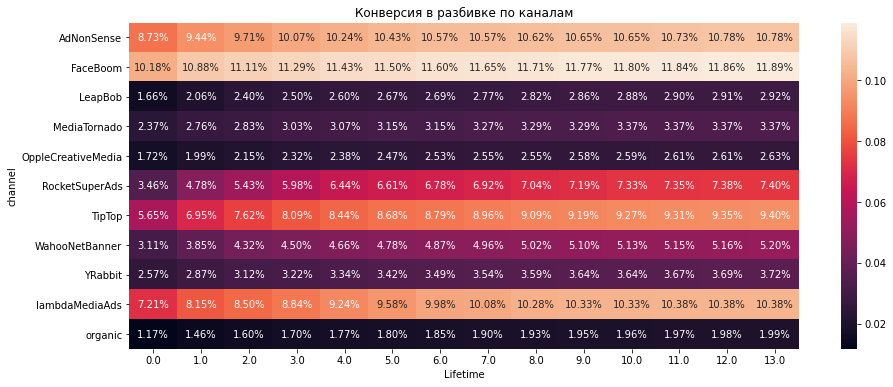

In [55]:
plt.figure(figsize=(15,6))
sns.heatmap(conversion.drop('cohort_size', axis=1), annot=True, fmt='.2%')
plt.xlabel('Lifetime')
plt.title('Конверсия в разбивке по каналам')
plt.show()

**Среди каналов с лучшей конверсией - TipTop, FaceBoom, AdMediaNonsense. Но даже приличные показатели конверсии не оправдывают затрачиваемые на них средства**

# Выводы

Новые пользователи были из 4 стран - США, Германии, Франции и Великобритании. Большая часть привлеченных пользователей родом из США - более 60%. 

Пользователи заходят с девайсов на Андроид, ПК и Макбуков, а большая часть - 36% - с Айфонов.

Большая часть юзеров приходят естественным способом - 37% из 150 тысяч. Среди каналов привлечения лидируют FaceBoom и TipTop, через которые пришло 19% и 13% пользователей, соответственно Оба этих канала работали на привлечение клиентов из США. Остальные каналы не превысили отметку в 6%.

TipTop и FaceBoom - лидеры по общим затратам на рекламу, расходы на них росли, особенно быстрым темпом - на TipTop. Но CAC рос только у TipTop с 1.5 до 3.5 - именно этот канал ответственен на рост CAC в целом. Стабильно высокий САС в районе единицы - у FaceBoom и AdNonSense(направлен на клиентов из Европы)

В целом наше приложение не приносит прибыли. На протяжении рассматриваемого периода общий LTV 14-го дня составил 0.9, ROI - 0.8. На графике истории LTV колеблется в промежутке от 0.8 до 1, а ROI стабильно падает, от 1.4 в мае до 0.65 к концу октября. САС за тот же период вырос с 0.8 до 1.3.

В разбивке по каналам аутсайдеры с ROI меньше нуля - TipTop, FaceBoom и AdNonSense. Наибольшую прибыльность показывают:
- MediaTornado, RocketSuperAds, YRabbit (США) 
- lambdaMediaAds, LeapBob (Европа)

При разбивке по странам у пользователей из США самый высокий LTV, но это сводится на нет очень высокими и постоянно растущими расходами на маркетинг. Европейские страны держатся на уровне 140-170% ROI 14 дня.

Пользователи из США удерживаются хуже, чем из других стран. То же касается и продукции Эппл в сравнении с другими платформами. Эти два факта взаимосвязаны - подавляющее большинство владельцев Айфонов и Макбуков как раз из США.

С конверсией все наоборот - она выше для пользователей продукции Apple из Соединенных штатов.

Каналы с лучшей конверсией - FaceBoom, TipTop, AdNonSense и lambdaMediaAds

# Рекомендации

**Стратегия привлечения клиентов из США должна быть как можно скорее пересмотрена и скорретирована**
- Основные каналы привлечения - TipTop и Faceboom - не окупают расходуемые средства. Стоит обратить внимание на MediaTornado, RocketSuperAds, YRabbit - их потенциал в настоящий момент гораздо выше.

**Для привлечения клиентов из Германии, Великобритании и Франции стоит активнее задействовать каналы LeapBob и lambdaMediaAds, а вот партнерство с AdNonSense имеет смысл прекратить**